딥러닝은 머신러닝의 한 방법이며, 신경망 모델이라 불리는
뇌의 신경 네트워크에서 힌트를 얻은 알고리즘

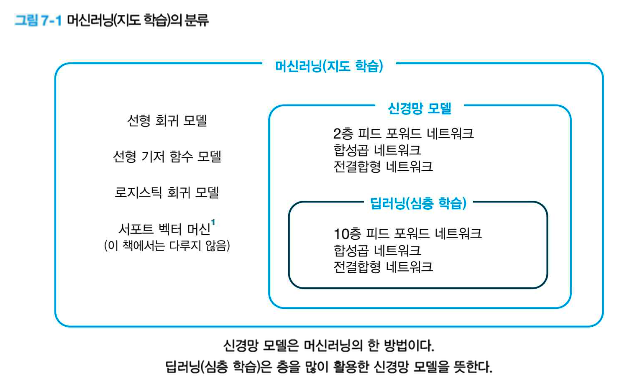

# 7.1
신경망 모델은 '뉴런 모델'단위로 구축

# 7.1.1 신경 세포
신경 세포는 축삭이라는 케이블을 가지고 있으며, 이 축삭을
사용하여 전기적 펄스를 다른 신경 세포에 전달. 축삭은
시냅스라고 불리는 인터페이스를 통해 펄스를 다음 신경 세포에 전달.


신경세포는 전기적 펄스로 막전위가 변하고, 시냅스 전달 강도에 따라
벼화 강도가 달라짐. 막전위가 일정 한계를 넘으면 전기적 펄스를 발산하며,
학습은 시냅스 전달 강도의 변화로 이루어짐

# 7.1.2 뉴런 모델
신경 세포의 움직임을 단순화한 수학적 모델인 뉴런 모델
뉴런에 2개의 입력 $x=(x_0, x_1)$가 들어오는 것을 가정

입력 총합을 시그모이드 함수에 넣어 $y$값을 구함.
$y$는 0부터 1까지 연속된 값을 가짐.

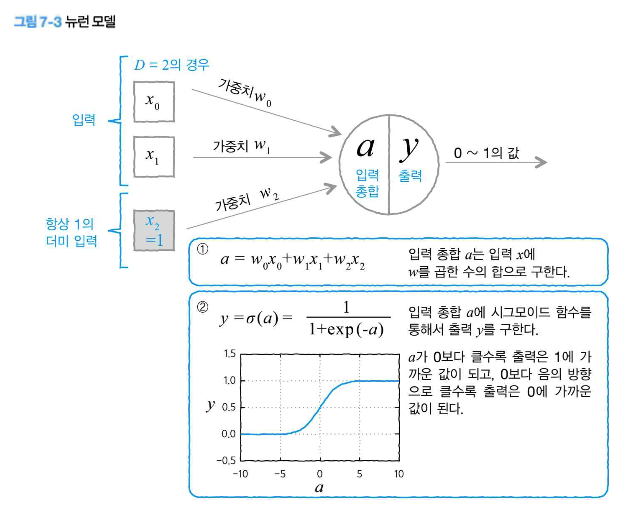

# 7.2 신경망 모델

# 7.2.1 2층 피드 포워드 신경망
신호가 되돌아가는 경로가 없이, 한 방향으로 흐르는 신경망

-> '피드 포워드 신경망'

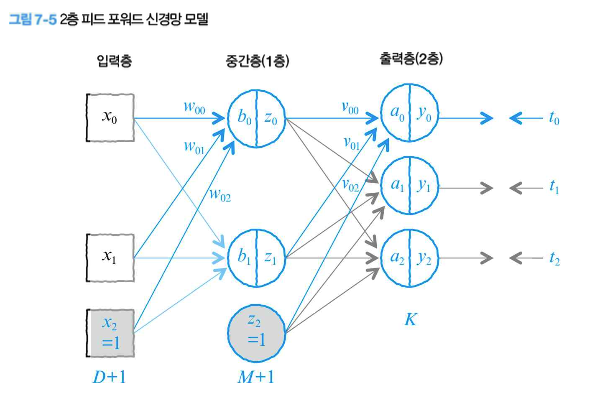

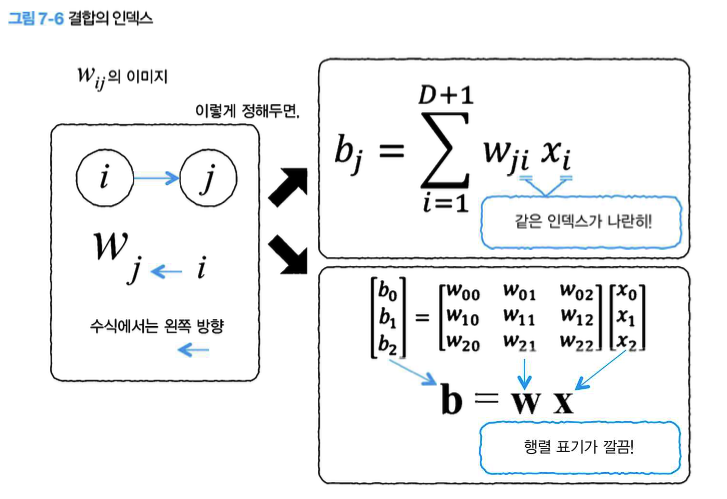

입력 차원을 $D$, 중간층 뉴런의 수를 $M$, 출력 차원을 $K$로 한 경우

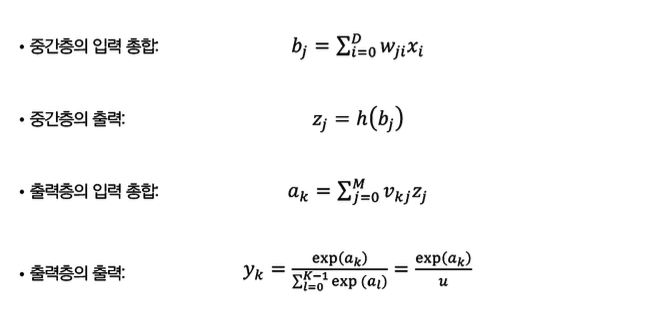

In [2]:
import numpy as np

np.random.seed(seed=1)
N = 200 # 데이터의 수
K = 3 # 분포의 수
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # x0의 범위, 표시용
X_range1 = [-3, 3] # x1의 범위
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
  wk = np.random.rand()
  for k in range(K):
    if wk < Pi[k]:
      T[n, k] = 1
      break
  for k in range(2):
    X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]

<ipython-input-2-2038042f579c>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]


오버 피팅이 일어나고 있지 않았는지 확인하기 위해 테스트 데이터 저장

In [3]:
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

np.savez('class_data.npz', X_train = X_train, T_train = T_train, X_test = X_test, T_test = T_test, X_range0 = X_range0, X_range1 = X_range1)

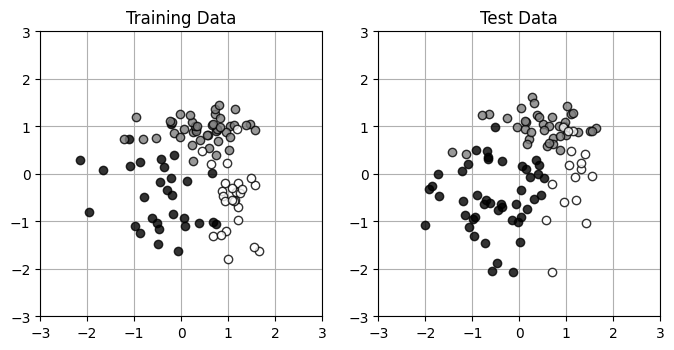

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0],[.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
             linestyle='none',
             marker='o', markeredgecolor='black',
             color=c[i], alpha=0.8)
    plt.grid(True)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

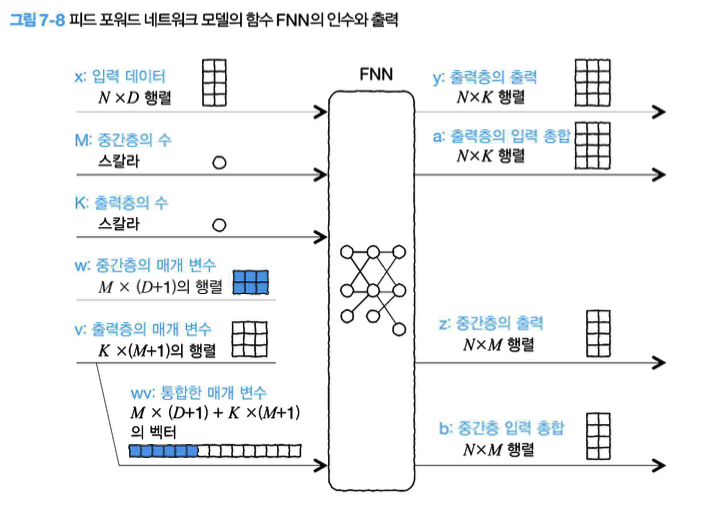

In [6]:
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def FNN(wv, M, K, x):
    N, D = x.shape # 입력 차원
    w = wv[:M * (D + 1)] # 중간층 뉴런의 가중치
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):] # 출력층 뉴런의 가중치

    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1)) # 중간층 뉴런의 입력 총합
    z = np.zeros((N, M + 1)) # 중간층 뉴런의 출력
    a = np.zeros((N, K)) # 출력층 뉴런의 입력 총합
    y = np.zeros((N, K)) # 출력층 뉴런의 출력
    for n in range(N):
        # 중간층의 계산
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) # (A)
            z[n, m] = Sigmoid(b[n, m])
        # 출력층의 계산
        z[n, M] = 1 # 더미 뉴런
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
    return y, a, z, b

WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

**M = 2** **K = 3** 인 **WV**는 2 * 3 + 3 * 3 = 15 인 가중치 벡터

**WV**의 요소를 모두 1로 하여, **X_train** 을 출력했을 때, 위와 같은 출력

# 7.2.3 수치 미분법
분류 문제
-> 평균 교차 엔트로피 오차 사용

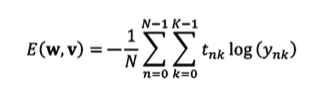

In [7]:
# 평균 교차 엔트로피 오차
def CE_FNN(wv, M, K, x, t):
  N, D = x.shape
  y, a, z, b = FNN(wv, M, K, x)
  ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
  return ce

WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

경사 하강법을 사용하려면 오차 함수를 매개 변수로 편미분한 식이 필요하지만, 사실은 미분 계산을 성실하게 하지 않아도 기울기를 갱신 가능

경사 하강법은 편미분을 계산하고, 마이너스를 곱한 방향으로 기울기를 갱신

수치 미분은 충분히 작은 숫자 앞에서 기울기의 근사 -> 미분 계산 안하고 근사적으로 경사 하강법 수행 가능

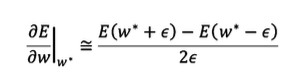

매개 변수가 여러 개일 경우, 하나를 제외하고 나머지를 고정시키고 편미분 근사

정밀도의 오차보다는 계산 비용이 큼

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


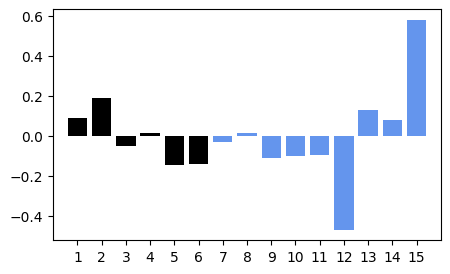

In [8]:
def dCE_FNN_num(wv, M, K, x, t):
  epsilon = 0.001
  dwv = np.zeros_like(wv)
  for iwv in range(len(wv)):
    wv_modified = wv.copy()
    wv_modified[iwv] = wv[iwv] - epsilon
    mse1 = CE_FNN(wv_modified, M, K, x, t)
    wv_modified[iwv] = wv[iwv] + epsilon
    mse2 = CE_FNN(wv_modified, M, K, x, t)
    dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
  return dwv

def Show_WV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color="black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
          align="center", color="cornflowerblue")
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

# 7.2.4 수치 미분법에 의한 경사 하강법

In [10]:
import time
# 수치 미분을 사용한 경사 하강법
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wvt = wv_init # 가중치 초기값
  err_train = np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n): # 학습 단계 수
    wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train) # train, test data 오차 계산
    err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wvt, M, K, x_test, t_test) # overfitting check
    wv_hist[i, :] = wvt
  return wvt, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:161.823 sec


훈련 데이터의 오차가 단조롭게 감소하여 일정한 값으로 수렴

테스트 데이터의 오차도 단순하게 떨어짐 -> 오버피팅 X

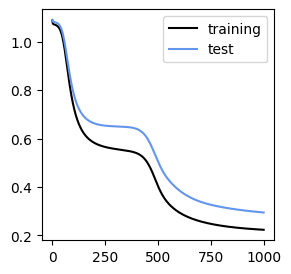

In [11]:
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
plt.show()

급격히 학습이 진행되는 구간이 있음

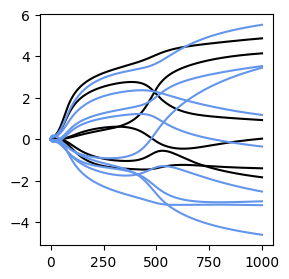

In [12]:
plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

가중치의 시간 변화 그래프

중간층 가중치 **w** -> 검정색

출력층 가중치 **v** -> 파란색

400 단계 부근에서 각각의 가중치 그래프가 교차하고 있음.
이것은 가중치를 갱신하는 방향, 즉 오차 함수의 기울기의 방향이 변화함을 의미

가중치가 안장점 근처를 통과?

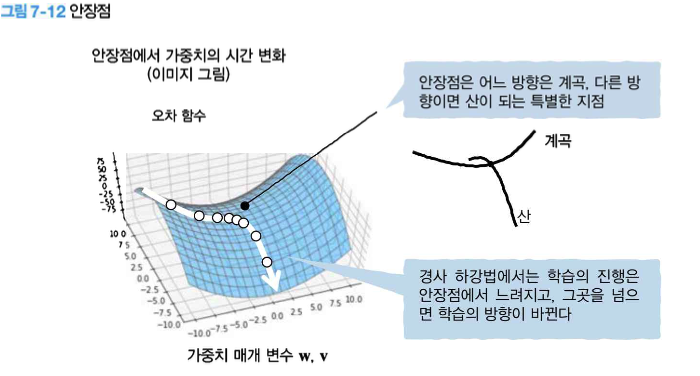

가중치 공간이 2차원이라고 가정하고 오차 함수를 그림

가중치가 중심에 가까워질수록 기울기가 작아지고, 갱신또한 느려짐.

그러나 어느정도 진행되면 방향 변화, 갱신 가속이 일어남

신경망에 의해 만들어지는 오차 함수는 복잡함.

특히 비선형성이 강하면 학습이 수렴해도 멈추지 않고 더 학습해서
급격하게 학습이 진행되는 경우가 많음

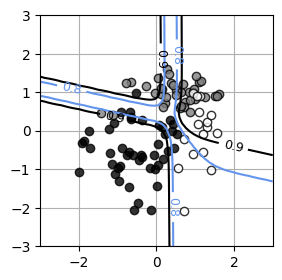

In [13]:
def show_FNN(wv, M, K):
  xn = 60
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
  y, a, z, b = FNN(wv, M, K, x)
  plt.figure(1, figsize=(4, 4))
  for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                       colors=['cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)

plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

수치 미분법에 의한 경사 하강법에서 얻은 클래스 간의 경계선 그래프

# 7.2.5 오차 역전파법

피드 포워드 신경망에 학습시키는 방법 -> 오차 역전파
(Backpropagation)

Backpropagation은 네트워크 출력에서 발생하는 오차 정보를 사용하여, 출력층의 가중치 $v_{kj}$에서 중간층에 가중치
$w_{ji}$으로 입력 방향의 반대로 가중치를 갱신함

평균 교차 엔트로피 오차는 데이터 각각의 교차 엔트로피 오차의 평균

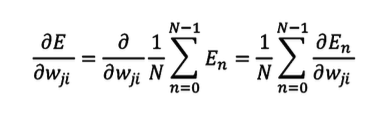

# 7.2.6 $\partial{E_n}$/$\partial{v_{ki}}$을 구하기

편미분의 체인룰을 사용하여 두 미분의 곱으로 분해

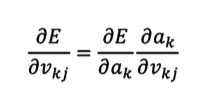

$E$는 앞서 말한 $E_n$.
식을 간단히 하기 위해 n 생략

$t,y$에 대해서만 식을 작성

$t_k$는 상수, $y_k$는 $a_0$의 함수로 확장

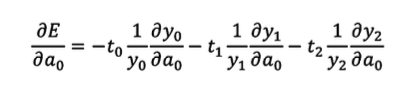

$\frac{\partial{E}}{\partial{a_k}}$는 출력층의 오차

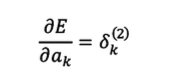

오차 함수에 제곱 오차를 사용

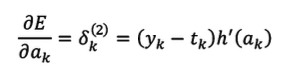

$h(x)$는 출력층 활성화 함수

활성화 함수로 시그모이드 함수 $\sigma(x)$를 사용한 경우

$h'(x) = (1-\sigma(x))\sigma(x)$

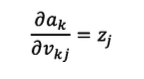

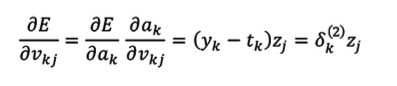

$v_{kj}$의 갱신 규칙

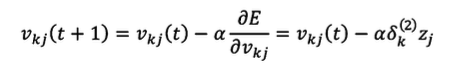

가중치 $v_{kj}$는 중간층의 뉴런 $j$에서 출력층의 뉴런 $k$에 정보를 전달하는 결합의 가중치

이 결합 변경의 크기는 입력 크기 $z_j$와 그 앞에서 생기는 오차
${\delta_k}^{(2)}$의 곱으로 결정

오차 ${\delta_k}^{(2)}$는 양수, 음수, 0도 존재하지만,
$z_j = \sigma(b_j)$이므로 항상 0~1 사이의 양수 값을 취함

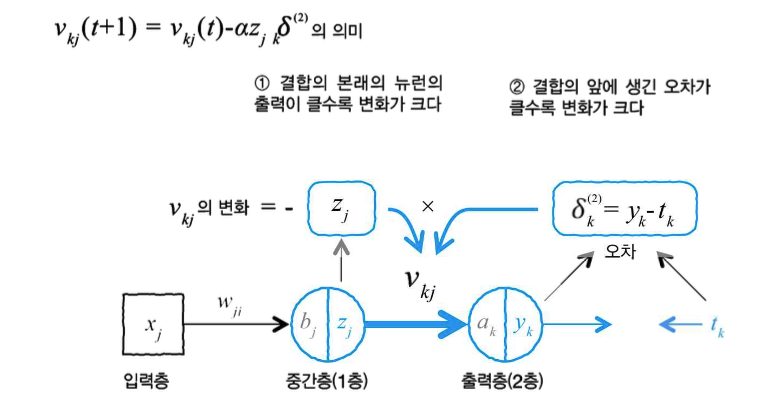

# 7.2.7 $\partial{E_n}$/$\partial{w_{ji}}$를 구하기
입력층에서 1층의 가중치 매개 변ㅇ수 $w_ji$의 학습 법칙을 도출

-> 오차 함수 $E$를 $w_{ji}$로 편미분

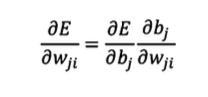

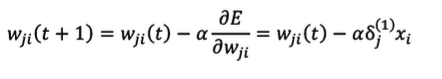

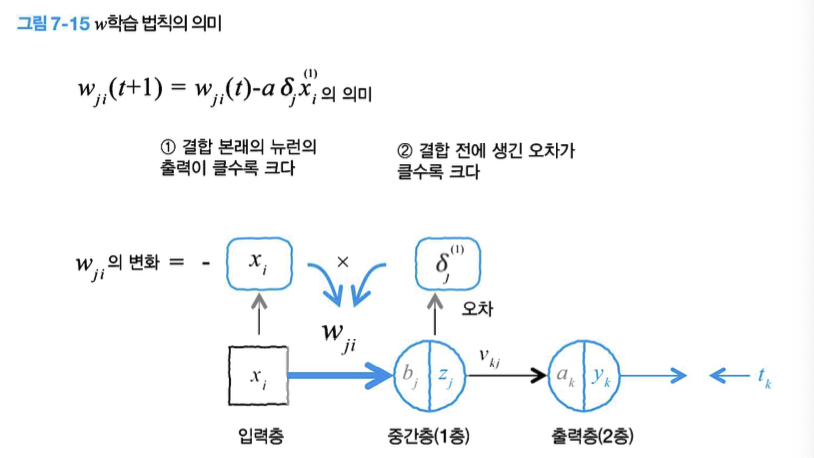

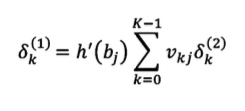

처음의 $h'(b_j)$는 활성화 함수의 미분이며 항상 양수

다음의 합에는 대상의 오차인 ${\delta_k}^{(2)}$을 $v_{kj}$의 가중치로 모으는 형태

즉, ${\delta_j}^{(1)}$는 결합한 곳에서 생긴 오차
${\delta_k}^{(2)}$를 반대 방향으로 전달시켜 계산

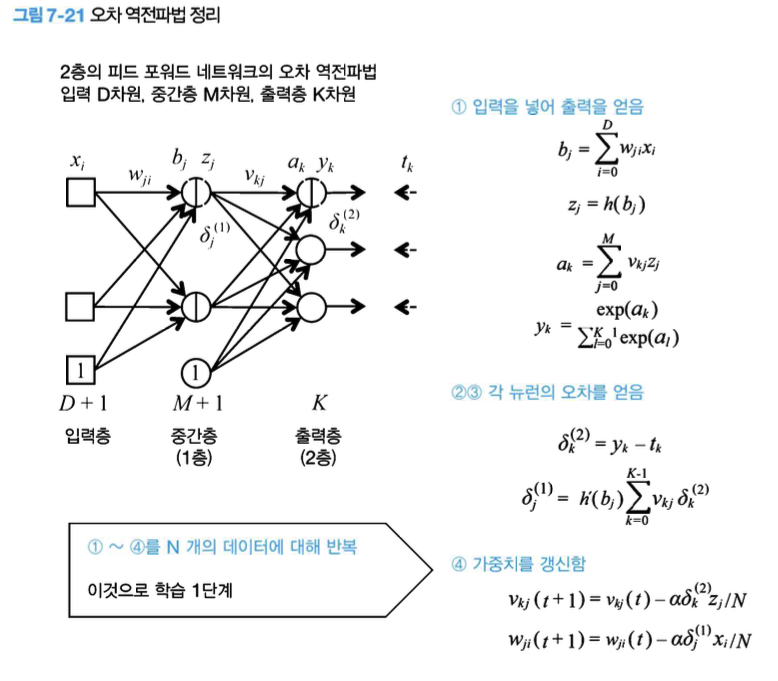

1. 네트워크에 x를 입력하고 출력 y를 얻음. 계산된 b,z,a도 보유해둠
2. 출력 y를 목표 데이터 t와 비교해 그 차이를 계산
3. 출력층의 오차를 사용하여 중간층의 오차를 계산
4. 결합 본래의 신호 강도와 결합처의 오차 정보를 사용하여 가중치 매개 변수를 갱신

# 7.2.8 오차 역전파법의 구현

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


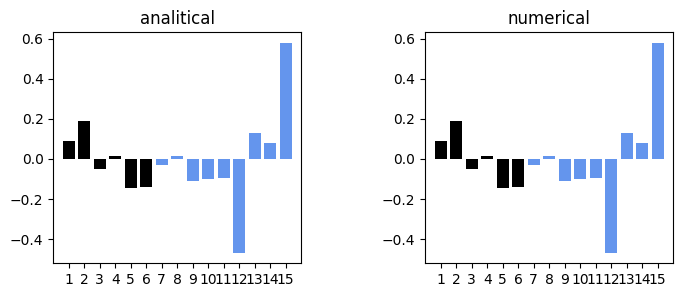

In [14]:
# 해석적 미분
def dCE_FNN(wv, M, K, x, t):
  N, D = x.shape
  # wv을 w와 v로 되돌림
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))
  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1))
  # x를 입력하여 y를 얻음
  y, a, z, b = FNN(wv, M, K, x)
  # 출력 변수의 준비
  dwv = np.zeros_like(wv)
  dw = np.zeros((M, D + 1))
  dv = np.zeros((K, M + 1))
  delta1 = np.zeros(M) # 1층 오차
  delta2 = np.zeros(K) # 2층 오차 (k = 0인 부분은 사용 안 함)
  for n in range(N):
    # 출력층의 오차 구하기
    for k in range(K):
      delta2[k] = (y[n, k] - t[n, k])
    # 중간층의 오차 구하기
    for j in range(M):
      delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
    # v의 기울기 dv를 구하기
    for k in range(K):
      dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
    # w의 기울기 dw를 구하기
    for j in range(M):
      dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
  # dw와 dv를 합체시킨 dwv로 만들기
  dwv = np.c_[dw.reshape((1, M * (D + 1))),
              dv.reshape((1, K * (M + 1)))]
  dwv = dwv.reshape(-1)
  return dwv

def Show_dWV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3],
          align = "center", color = "black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
          align="center", color='cornflowerblue')
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

# 동작 확인
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)


dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

In [15]:
import time

# 해석적 미분법을 사용한 경사 하강법
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wv = wv_init.copy()
  err_train =  np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n):
    wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train)
    err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
    wv_hist[i, :] = wv
  return wv, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))


Calculation time:25.103 sec


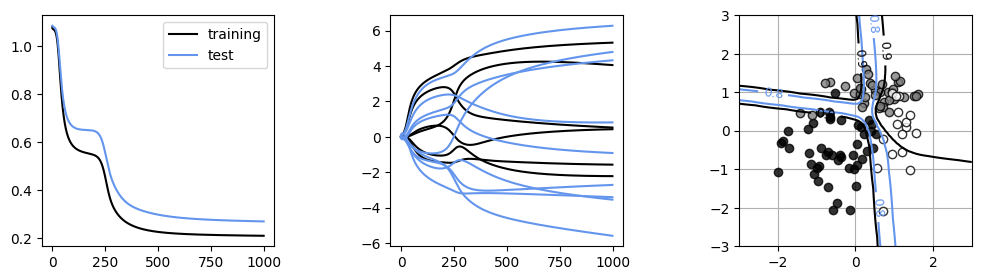

In [16]:
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

수치 미분과 해석적 미분은 결과가 거의 동일하지만,
해석적 미분이 계산이 훨씬 빨리 끝남

수치 미분은 도출된 미분 방정식을 확인하는 도구

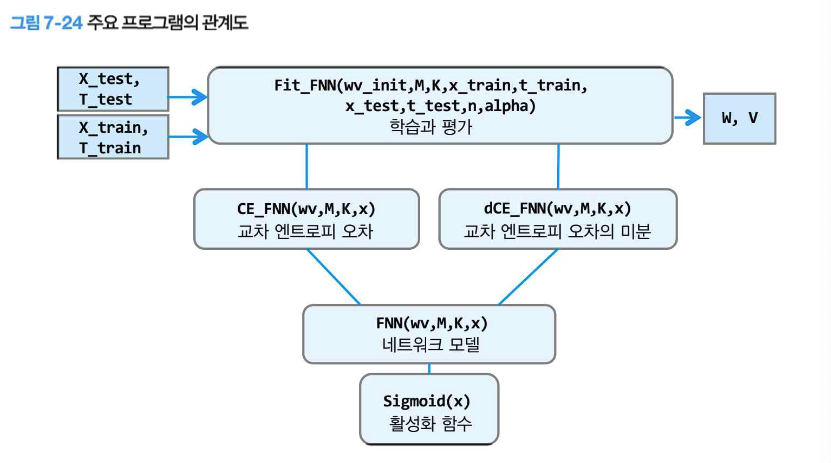

# 7.2.9 학습 후 뉴런의 특성

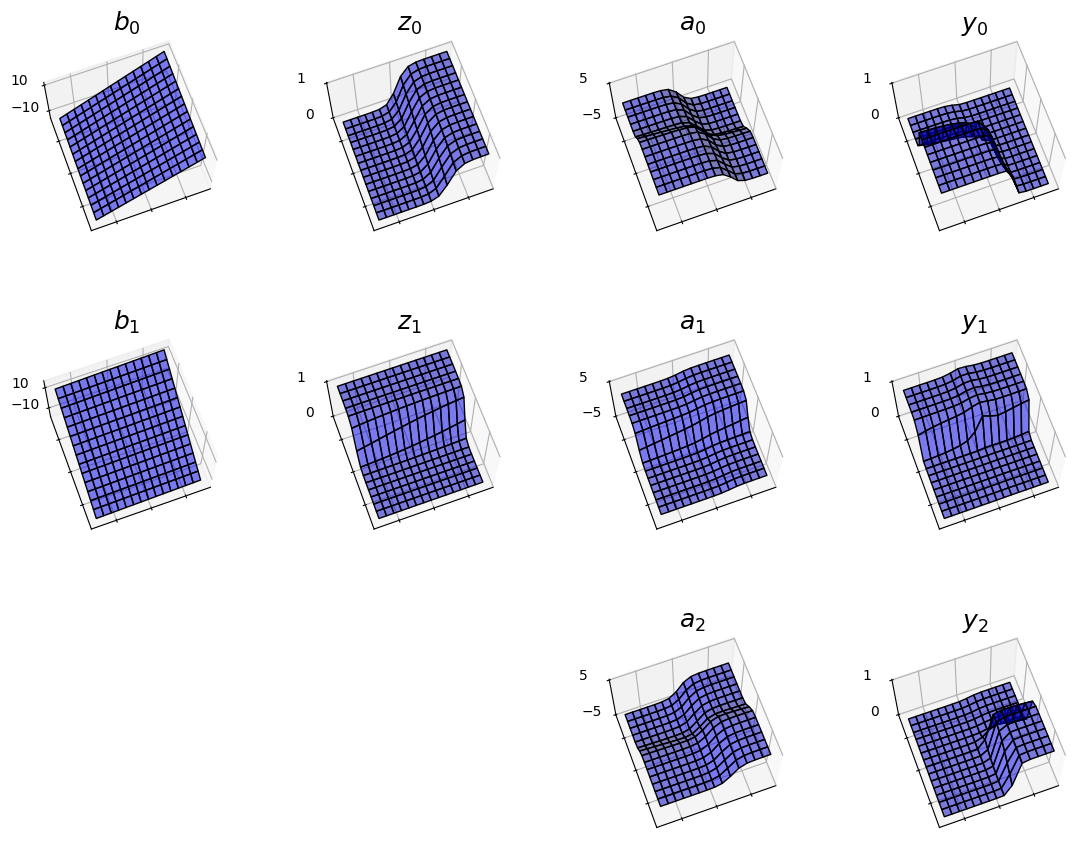

In [17]:
from mpl_toolkits.mplot3d import Axes3D

def show_activation3d(ax, v, v_ticks, title_str) :
  f = v.copy()
  f = f.reshape(xn, xn)
  f = f.T

  ax.plot_surface(xx0, xx1, f, color = 'blue', edgecolor = 'black', rstride = 1, cstride = 1, alpha = 0.5)
  ax.view_init(70, -110)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticks(v_ticks)
  ax.set_title(title_str, fontsize = 18)

M = 2
K = 3
xn = 15 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)

x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # 1 -> 'F'
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize = (12, 9))
plt.subplots_adjust(left = 0.075, bottom = 0.05, right = 0.95, top = 0.95, wspace = 0.4, hspace = 0.4)

for m in range(M) :
  ax = fig.add_subplot(3, 4, 1 + m * 4, projection = '3d')
  show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))

  ax = fig.add_subplot(3, 4, 2 + m * 4, projection = '3d')
  show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))


for k in range(K) :
  ax = fig.add_subplot(3, 4, 3 + k * 4, projection = '3d')
  show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))

  ax = fig.add_subplot(3, 4, 4 + k * 4, projection = '3d')
  show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))

plt.show()

# 7.3 케라스로 신경망 모델 구현

# 7.3.1 2층 피드 포워드 신경망

In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1)
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation

outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [27]:
def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
             linestyle='none', marker='o',
             markeredgecolor='black',
             color=c[i], alpha=0.8)
  plt.grid(True)

In [21]:
# 난수 초기화
np.random.seed(1)

# ---- Sequential 모델 자석
model = Sequential()

model.add(Dense(2, input_dim = 2, activation = 'sigmoid', kernel_initializer = 'uniform')) # (A)
model.add(Dense(3, activation = 'softmax', kernel_initializer = 'uniform')) # (B)
sgd = keras.optimizers.SGD(learning_rate = 1, momentum = 0.0, nesterov = False) # (C) #decay인수 사라짐

model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy']) # (D)

# ---- 학습
startTime = time.time()
history = model.fit(X_train, T_train, epochs = 1000, batch_size = 100, verbose = 0, validation_data = (X_test, T_test)) # (E)

# ---- 모델평가
score = model.evaluate(X_test, T_test, verbose = 0) # (F)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'.format(score[0], score[1]))

calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.26, accuracy 0.90
Calculation time:41.995 sec


113/113 [==============================] - 1s 5ms/step


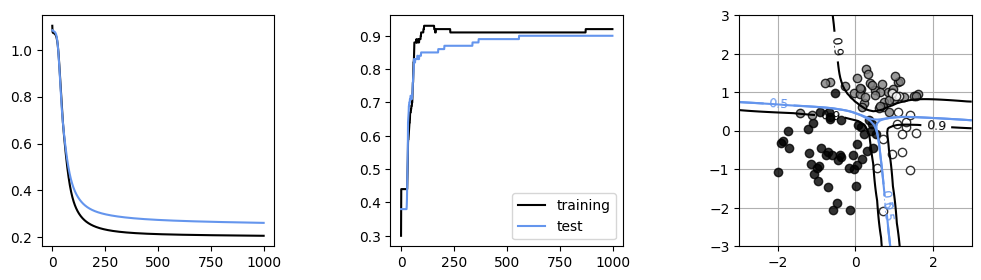

In [28]:
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace = 0.5)

# 학습 곡선 표시 ----
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label = 'training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label = 'test') # (B)

# 정확도 표시 ----
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], 'black', label = 'training') # (C) 'acc' -> 'accuracy'
plt.plot(history.history['val_accuracy'], 'cornflowerblue', label = 'test') # (D) 'val_acc' -> 'val_accuracy'
plt.legend()

# 경계선 표시 ----
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)

x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # 1 -> 'F'
y = model.predict(x) #(E)

K = 3
for ic in range(K) :
  f = y[:, ic]
  f = f.reshape(xn, xn)
  f = f.T

  cont = plt.contour(xx0, xx1, f, levels = [0.5, 0.9], colors = ['cornflowerblue', 'black'])
  cont.clabel(fmt = '%1.1f', fontsize = 9)
  plt.xlim(X_range0)
  plt.ylim(X_range1)

plt.show()
